In [3]:
import numpy as np 
import pandas as pd 
import os
import re
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
#Image Super Resolution
base_directory = 'ImSuRe'
hires_folder = os.path.join(base_directory, 'high res')
lowres_folder = os.path.join(base_directory, 'low res')


data = pd.read_csv("ImSuRe/image_data.csv")
data['low_res'] = data['low_res'].apply(lambda x: os.path.join(lowres_folder,x))
data['high_res'] = data['high_res'].apply(lambda x: os.path.join(hires_folder,x))
data.head()

,low_res,high_res
0,ImSuRe/low res/1_2.jpg,ImSuRe/high res/1.jpg
1,ImSuRe/low res/2_2.jpg,ImSuRe/high res/2.jpg
2,ImSuRe/low res/3_2.jpg,ImSuRe/high res/3.jpg
3,ImSuRe/low res/4_2.jpg,ImSuRe/high res/4.jpg
4,ImSuRe/low res/5_2.jpg,ImSuRe/high res/5.jpg


In [5]:
batch_size =2

image_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15)
mask_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15)

train_hiresimage_generator = image_datagen.flow_from_dataframe(
        data,
        x_col='high_res',
        target_size=(800, 1200),
        class_mode = None,
        batch_size = batch_size,
        seed=42,
        subset='training')

train_lowresimage_generator = image_datagen.flow_from_dataframe(
        data,
        x_col='low_res',
        target_size=(800, 1200),
        class_mode = None,
        batch_size = batch_size,
        seed=42,
        subset='training')

val_hiresimage_generator = image_datagen.flow_from_dataframe(
        data,
        x_col='high_res',
        target_size=(800, 1200),
        class_mode = None,
        batch_size = batch_size,
        seed=42,
        subset='validation')

val_lowresimage_generator = image_datagen.flow_from_dataframe(
        data,
        x_col='low_res',
        target_size=(800, 1200),
        class_mode = None,
        batch_size = batch_size,
        seed=42,
        subset='validation')

Found 3198 validated image filenames.
Found 3198 validated image filenames.
Found 564 validated image filenames.
Found 564 validated image filenames.


In [6]:
train_generator = zip(train_lowresimage_generator, train_hiresimage_generator)
val_generator = zip(val_lowresimage_generator, val_hiresimage_generator)

def imageGenerator(train_generator):
    for (low_res, hi_res) in train_generator:
            yield (low_res, hi_res)


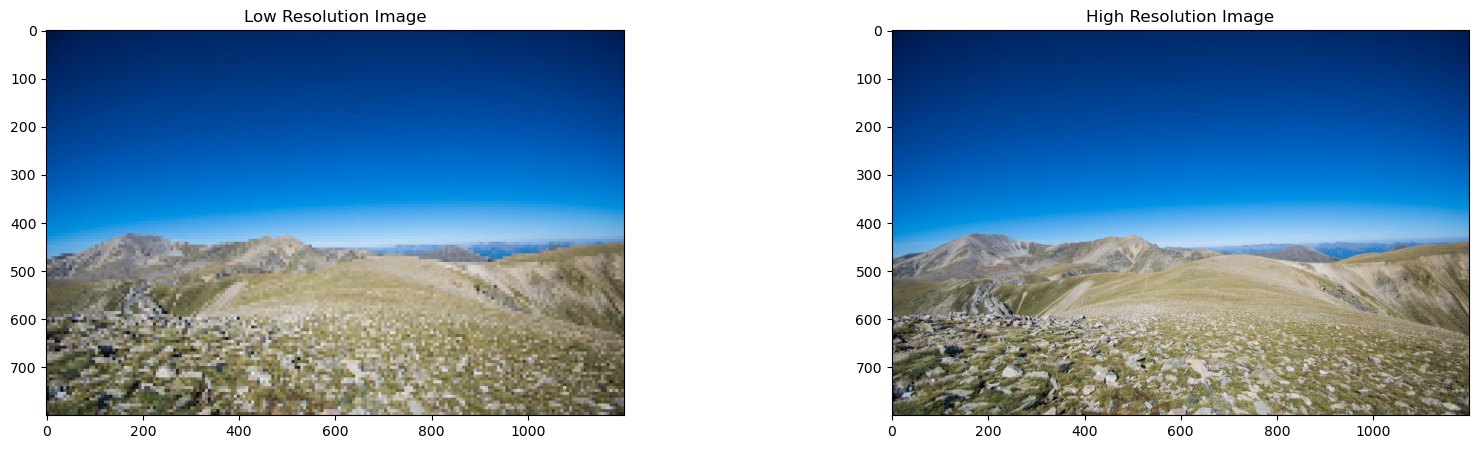

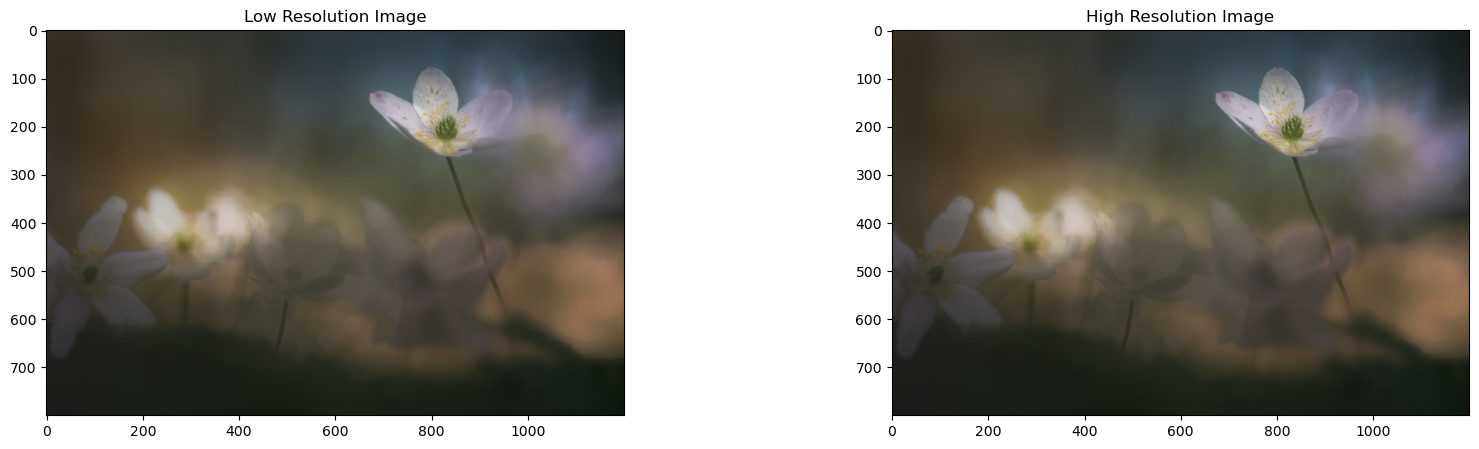

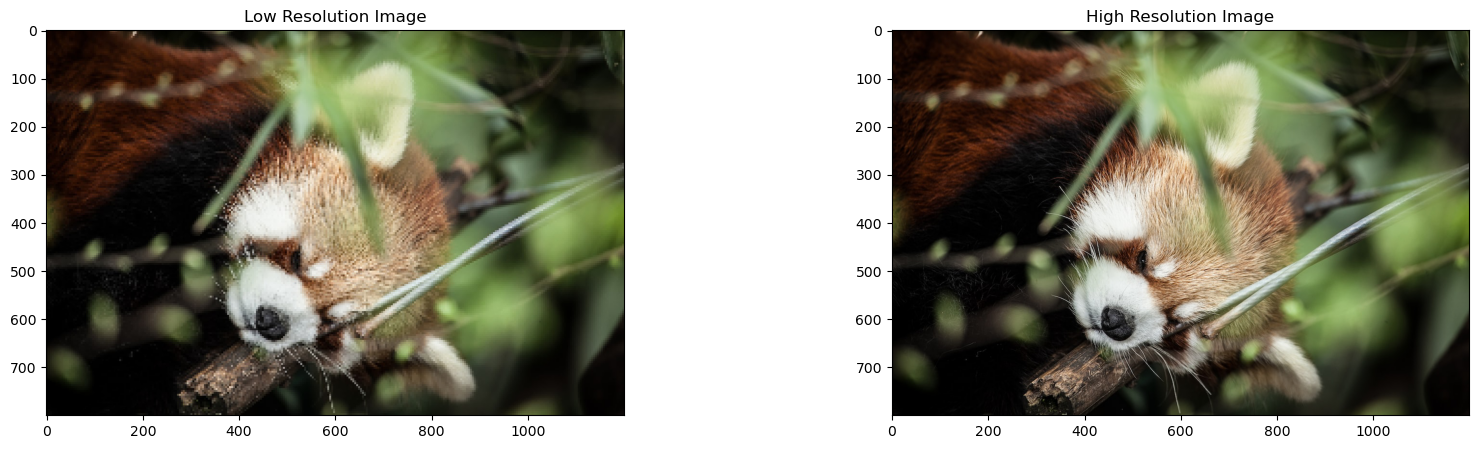

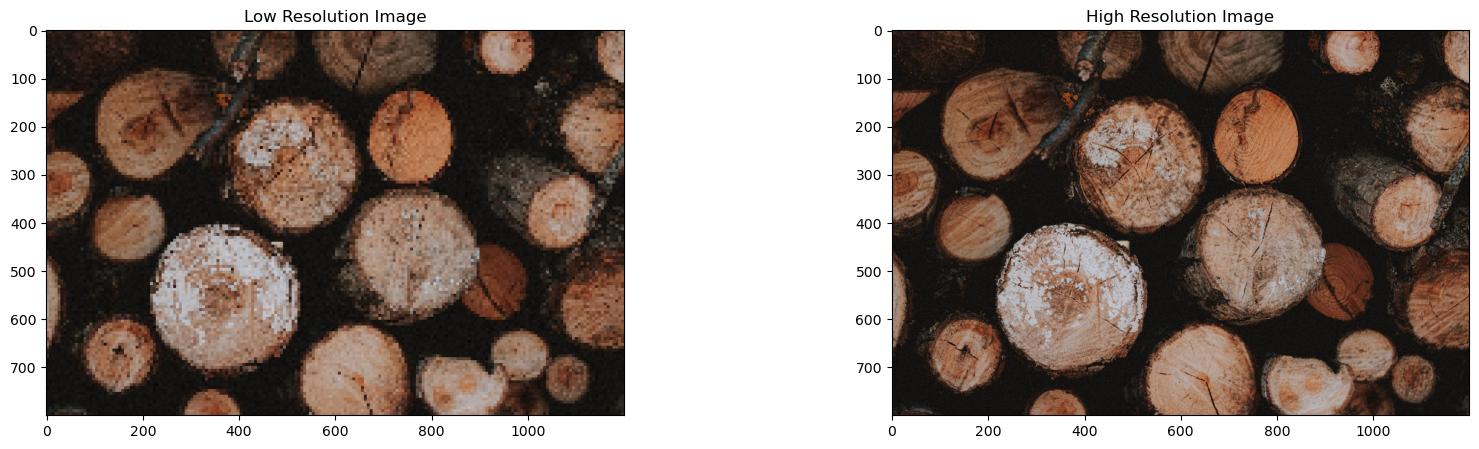

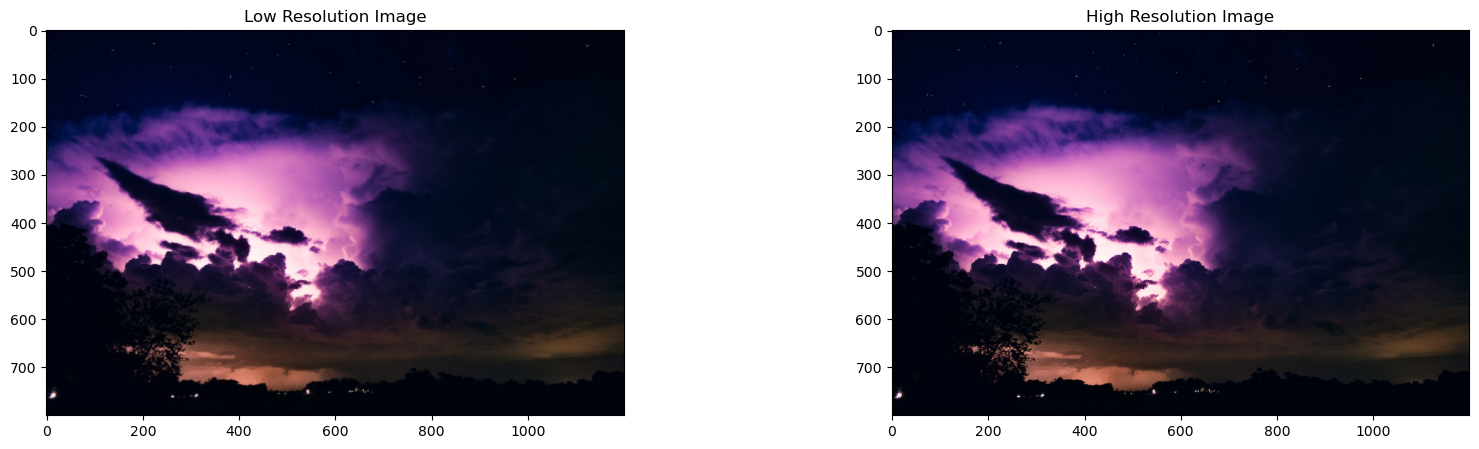

In [7]:
#Data Visualization
n = 0
for i,m in train_generator:
    img,out = i,m

    if n < 5:
        fig, axs = plt.subplots(1 , 2, figsize=(20,5))
        axs[0].imshow(img[0])
        axs[0].set_title('Low Resolution Image')
        axs[1].imshow(out[0])
        axs[1].set_title('High Resolution Image')
        plt.show()
        n+=1
    else:
        break

In [8]:
#Autoencoders
input_img = Input(shape=(800, 1200, 3))

l1 = Conv2D(64, (3, 3), padding='same', activation='relu')(input_img)
l2 = Conv2D(64, (3, 3), padding='same', activation='relu')(l1)
l3 = MaxPooling2D(padding='same')(l2)
l3 = Dropout(0.3)(l3)
l4 = Conv2D(128, (3, 3),  padding='same', activation='relu')(l3)
l5 = Conv2D(128, (3, 3), padding='same', activation='relu')(l4)
l6 = MaxPooling2D(padding='same')(l5)
l7 = Conv2D(256, (3, 3), padding='same', activation='relu')(l6)

l8 = UpSampling2D()(l7)

l9 = Conv2D(128, (3, 3), padding='same', activation='relu')(l8)
l10 = Conv2D(128, (3, 3), padding='same', activation='relu')(l9)

l11 = add([l5, l10])
l12 = UpSampling2D()(l11)
l13 = Conv2D(64, (3, 3), padding='same', activation='relu')(l12)
l14 = Conv2D(64, (3, 3), padding='same', activation='relu')(l13)

l15 = add([l14, l2])

decoded = Conv2D(3, (3, 3), padding='same', activation='relu')(l15)

autoencoder = Model(input_img, decoded)

2023-02-10 01:06:36.510498: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-10 01:06:36.510532: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (picox): /proc/driver/nvidia/version does not exist
2023-02-10 01:06:36.525039: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 800, 1200,   0           []                               
                                3)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 800, 1200, 6  1792        ['input_1[0][0]']                
                                4)                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 800, 1200, 6  36928       ['conv2d[0][0]']                 
                                4)                                                            

In [10]:
#Model Training
train_samples = train_hiresimage_generator.samples
val_samples = val_hiresimage_generator.samples

train_img_gen = imageGenerator(train_generator)
val_image_gen = imageGenerator(val_generator)


In [11]:
model_path = "autoencoder.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 9,
                          verbose = 1,
                          restore_best_weights = True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)


In [2]:
nepochs=5
hist = autoencoder.fit(train_img_gen,
                    steps_per_epoch=train_samples//batch_size,
                    validation_data=val_image_gen,
                    validation_steps=val_samples//batch_size,
                    epochs=nepochs, callbacks=[earlystop, checkpoint, learning_rate_reduction])


NameError: name 'autoencoder' is not defined

In [3]:
plt.figure(figsize=(20,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: name 'plt' is not defined

In [4]:
n = 0
for i,m in val_generator:
    img,mask = i,m
    sr1 = autoencoder.predict(img)
    if n < 20:
        fig, axs = plt.subplots(1 , 3, figsize=(20,4))
        axs[0].imshow(img[0])
        axs[0].set_title('Low Resolution Image')
        axs[1].imshow(mask[0])
        axs[1].set_title('High Resolution Image')
        axs[2].imshow(sr1[0])
        axs[2].set_title('Predicted High Resolution Image')
        plt.show()
        n+=1
    else:
        break

NameError: name 'val_generator' is not defined